**Датасет взят с:** https://www.kaggle.com/datasets/itssuru/bike-sharing-system-washington-dc?select=test_bikes.csv

# Задание

Этот набор данных содержит почасовой и ежедневный подсчет проката велосипедов в период с 2011 по 2012 год в системе проката велосипедов Capital в Вашингтоне, округ Колумбия, с соответствующей информацией о погоде и сезоне.


Вы должны предсказать oбщее количество арендованных велосипедов (сount) в течение каждого часа, охваченного тестовым набором, используя только информацию, доступную до периода аренды.

# Импортируем исходные библиотеки:

In [25]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from  sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import GridSearchCV
from  sklearn.model_selection import cross_val_score


from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE

# Импортируем исходный датасет:

    1. Производим импорт:

*ЗНАЧЕНИЯ КОЛОНОК:*

***season***: Season (1:springer, 2:summer, 3:fall, 4:winter)

***holiday***: weather day is holiday or not (extracted from Holiday Schedule)

***weekday***: Day of the week

***workingday***: If day is neither weekend nor holiday is 1, otherwise is 0.

***weather***: (extracted from Freemeteo)
1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

***temp***: temperature in Celsius.

***atemp***: feeling temperature in Celsius.

***hum***: humidity

***windspeed***: Normalized wind speed. The values are divided to 67 (max)

***casual***: count of casual users

***registered***: count of registered users

***count***: count of total rental bikes including both casual and registered

In [2]:
path = r"C:\Users\-\Documents\bikes\train_bikes.csv"

df = pd.read_csv(path, parse_dates=['datetime'])

# Добавим новые столбцы:
df['day_of_week'] = df.datetime.apply(lambda x: x.day_of_week)
df['month'] = df.datetime.apply(lambda x: x.month)
df['date'] = df.datetime.apply(lambda x: x.floor('1D'))
df['hour'] = df.datetime.apply(lambda x: x.hour)

df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,day_of_week,month,date,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,5,1,2011-01-01,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,5,1,2011-01-01,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,5,1,2011-01-01,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,5,1,2011-01-01,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,5,1,2011-01-01,4


    2. Смотрим характеристики датафрейма:

In [3]:
# Размер:
df.shape

(10886, 16)

In [4]:
# Типы данных столбцов:
df.dtypes

datetime       datetime64[ns]
season                  int64
holiday                 int64
workingday              int64
weather                 int64
temp                  float64
atemp                 float64
humidity                int64
windspeed             float64
casual                  int64
registered              int64
count                   int64
day_of_week             int64
month                   int64
date           datetime64[ns]
hour                    int64
dtype: object

In [5]:
# Кол-во уник. значений столбцов:
for col in df.columns:
    print(f'Столбец {col}: {df[col].nunique()} уник. значения')

Столбец datetime: 10886 уник. значения
Столбец season: 4 уник. значения
Столбец holiday: 2 уник. значения
Столбец workingday: 2 уник. значения
Столбец weather: 4 уник. значения
Столбец temp: 49 уник. значения
Столбец atemp: 60 уник. значения
Столбец humidity: 89 уник. значения
Столбец windspeed: 28 уник. значения
Столбец casual: 309 уник. значения
Столбец registered: 731 уник. значения
Столбец count: 822 уник. значения
Столбец day_of_week: 7 уник. значения
Столбец month: 12 уник. значения
Столбец date: 456 уник. значения
Столбец hour: 24 уник. значения


    3. Смотрим наличие выбросов:

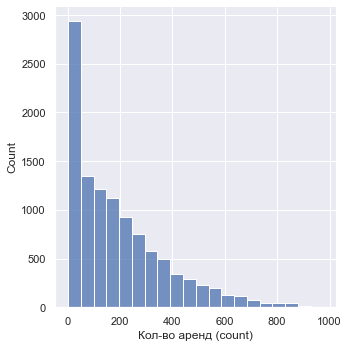

In [6]:
# Значения целевой переменной не содержат явных выбросов (распределение логнормальное):

sns.set_theme()
sns.displot(data=df, x='count', bins=20).set(xlabel='Кол-во аренд (count)')
sns.despine()

# Кодируем категориальные признаки с помощью OneHotEncoder:

    1. Функция, преобразующая столбец с помощью OneHotEncoder:

In [7]:
def get_dummy(col, label):
    return pd.get_dummies(df[col].apply(lambda x: label+'_'+str(x)))

    2. Каждый категориальный столбец заменим с помощью OneHotEncoder:

In [8]:
cols = ['season', 'holiday', 'workingday', 'weather', 'day_of_week', 'month', 'hour']

for col in cols:
    df = pd.concat([df, get_dummy(col, col)], axis=1)

df = df.drop(cols, axis=1)

# Создание и выбор наилучшей модели:

    1. Делим исходный датафрейм на зависимые и независимую переменную:

In [9]:
data = df.drop(['datetime', 'registered', 'count', 'date','casual'], axis=1)
target = df['count']

    2. Визуализируем корреляцию признаков:

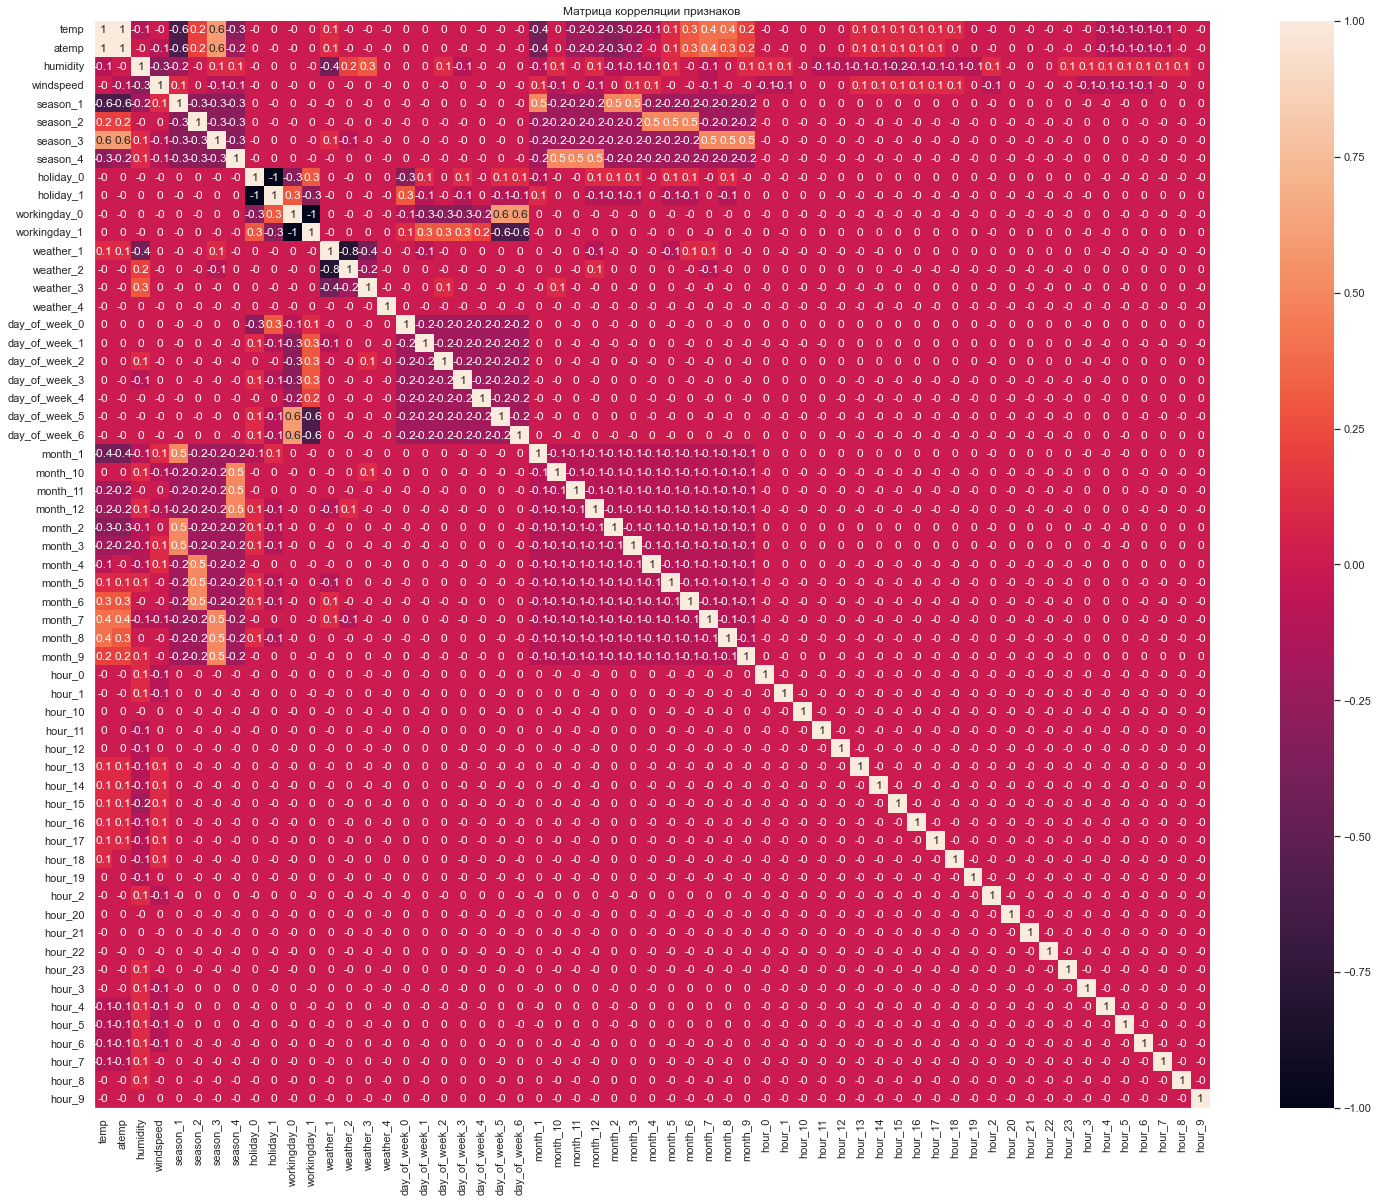

In [10]:
matrix = data.corr().applymap(lambda x: round(x,1))
fig, ax = plt.subplots(figsize=(25,20)) 
sns.heatmap(data=matrix, annot = True, ax=ax).set(title='Матрица корреляции признаков')
sns.despine()

    3. Сплитуем на тренировочную и тестовую выборки:

In [11]:
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=1)

    4. Создаем модели с целью отбора наилучшую для нашей задачи:

*Выбираем регрессионные модели: RandomForestRegressor, DecisionTreeRegressor и LinearRegressor.*

In [12]:
# Делаем пробные экземпляры моделей (проверка на минимальную работоспособность):

rf = RandomForestRegressor(n_jobs=-1).fit(X_train, y_train)
tree = DecisionTreeRegressor().fit(X_train, y_train)
lr =  LinearRegression().fit(X_train, y_train)

In [13]:
# На первый взгляд модель RandomForestRegressor показывает наилучший результат:

print(f'RandomForestRegressor R²:     {round(rf.score(X_test, y_test),2)}')
print(f'RandomForestRegressor RMSE:  {round(np.sqrt(MSE(y_test, rf.predict(X_test))),2)}')
print(f'RandomForestRegressor MAE:   {round(MAE(y_test, rf.predict(X_test)),2)}')

print(f'\nDecisionTreeRegressor R²:      {round(tree.score(X_test, y_test),2)}')
print(f'DecisionTreeRegressor RMSE:  {round(np.sqrt(MSE(y_test, tree.predict(X_test))),2)}')
print(f'DecisionTreeRegressor MAE:    {round(MAE(y_test, tree.predict(X_test)),2)}')

print(f'\nLinearRegression R²:           {round(lr.score(X_test, y_test),2)}')
print(f'LinearRegression RMSE:       {round(np.sqrt(MSE(y_test, lr.predict(X_test))),2)}')
print(f'LinearRegression MAE:         {round(MAE(y_test, lr.predict(X_test)),2)}')

RandomForestRegressor R²:     0.84
RandomForestRegressor RMSE:  73.48
RandomForestRegressor MAE:   49.24

DecisionTreeRegressor R²:      0.69
DecisionTreeRegressor RMSE:  103.27
DecisionTreeRegressor MAE:    64.16

LinearRegression R²:           0.63
LinearRegression RMSE:       111.49
LinearRegression MAE:         80.26


    5. Проведем кросс-валидацию с помощью решетчатого поиска:

*5.1 Для RandomForestRegressor:*

In [14]:
%%time

parametrs = { 'n_estimators': range (100, 1000, 100),
              'max_depth': range (11,30, 2) }

rf = RandomForestRegressor()
grid_rf = GridSearchCV(rf, parametrs, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')
grid_rf.fit(data, target)

Wall time: 14min 48s


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': range(11, 30, 2),
                         'n_estimators': range(100, 1000, 100)},
             scoring='neg_mean_absolute_error')

In [24]:
# Лучше результаты кросс-валидации:

cv_results = pd.DataFrame(grid_rf.cv_results_)
cv_results['mean_test_score'] = -cv_results['mean_test_score']
cv_results.sort_values('mean_test_score').head(3)[['mean_test_score', 'std_test_score', 'params']]

,mean_test_score,std_test_score,params
70,83.217233,7.862572,"{'max_depth': 25, 'n_estimators': 800}"
71,83.278683,7.903625,"{'max_depth': 25, 'n_estimators': 900}"
73,83.304495,7.726668,"{'max_depth': 27, 'n_estimators': 200}"


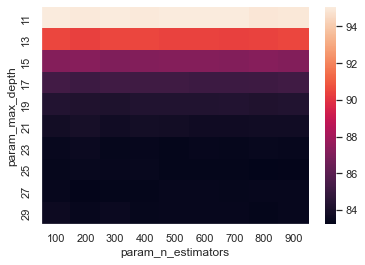

In [53]:
# Тепловая карта кросс-валидированного MAE в зависимости от n_estimators и max_depth:

heat_data = cv_results.pivot(index   = 'param_max_depth', 
                             columns = 'param_n_estimators', 
                             values  = 'mean_test_score')
sns.heatmap(heat_data)
sns.despine()

*5.2 Для DecisionTreeRegressor:*

In [55]:
%%time

parametrs = { 'max_depth': range (11,50, 2),
             'min_samples_split': range(2,8,2),
             'min_samples_leaf': range(1,8,2)}

tree = DecisionTreeRegressor()
grid_tree = GridSearchCV(tree, parametrs, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')
grid_tree.fit(data, target)

Wall time: 9.56 s


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': range(11, 50, 2),
                         'min_samples_leaf': range(1, 8, 2),
                         'min_samples_split': range(2, 8, 2)},
             scoring='neg_mean_absolute_error')

In [56]:
# Лучше результаты кросс-валидации:

cv_results = pd.DataFrame(grid_tree.cv_results_)
cv_results['mean_test_score'] = -cv_results['mean_test_score']
cv_results.sort_values('mean_test_score').head(3)[['mean_test_score', 'std_test_score', 'params']]

,mean_test_score,std_test_score,params
70,89.736481,7.101898,"{'max_depth': 21, 'min_samples_leaf': 7, 'min_..."
69,89.758192,7.133140,"{'max_depth': 21, 'min_samples_leaf': 7, 'min_..."
71,89.854753,7.187032,"{'max_depth': 21, 'min_samples_leaf': 7, 'min_..."


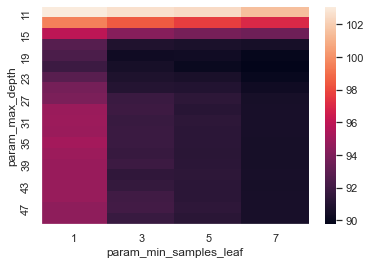

In [65]:
# Тепловая карта кросс-валидированного MAE в зависимости от min_samples_split и max_depth:

heat_data = cv_results.drop_duplicates(['param_max_depth','param_min_samples_leaf'])\
                      .pivot(index   = 'param_max_depth', 
                             columns = 'param_min_samples_leaf', 
                             values  = 'mean_test_score')
sns.heatmap(heat_data)
sns.despine()

*5.3 Для LinearRegression:*

In [66]:
cv_score = cross_val_score(lr, data, target, cv=10, scoring='neg_mean_absolute_error')

# Имеется выброс в полученных MAE, но даже с его учетом, у модели худшие показатели:
print(f'Средний MAE при кросс-валидации: {round(np.mean(list(cv_score))*(-1),2)}')
print(f'Медианный MAE при кросс-валидации: {round(np.median(list(cv_score))*(-1),2)}')

Средний MAE при кросс-валидации: 222152160.6
Медианный MAE при кросс-валидации: 96.77


    6. Делаем вывод, что наиболее подходящая модель - RandomForestRegressor с параметрами:

In [52]:
grid_rf.best_params_

{'max_depth': 25, 'n_estimators': 800}

    7. Создаем модель с оптимальными параметрами:

In [67]:
rf = RandomForestRegressor(n_estimators=800, max_depth=25, n_jobs=-1).fit(X_train, y_train)

    8. Сравним предсказания модели с истинными значениями тестовой выборки:

In [105]:
# Функция, строящая график предсказанных и истинных значений для разных интервалов точек данных:

def get_pred_plot(first, last):
    fig, ax = plt.subplots(figsize=(35,5)) 

    predictions_count = rf.predict(X_test)

    plt.plot(range(first, last), y_test[first:last:])
    plt.plot(range(first, last), predictions_count[first:last:])

    plt.xlabel('Порядковый номер точки данных')
    plt.ylabel('Общее количество юзеров (count users)')

    plt.grid(visible=True)
    plt.legend(["true", "predicted"], loc ="upper left", prop={'size': 25})
    sns.despine()

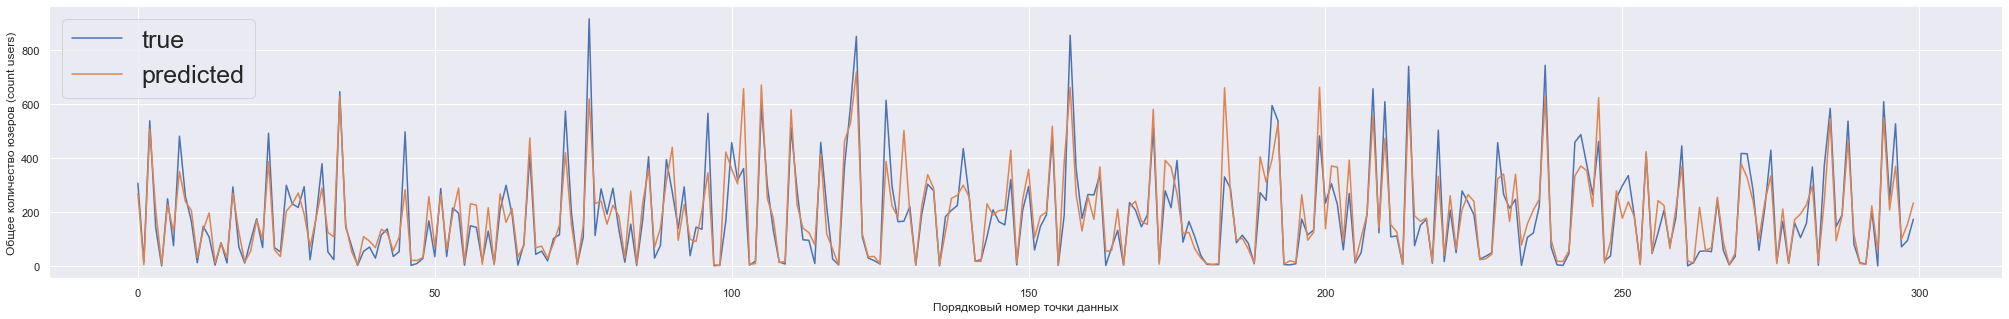

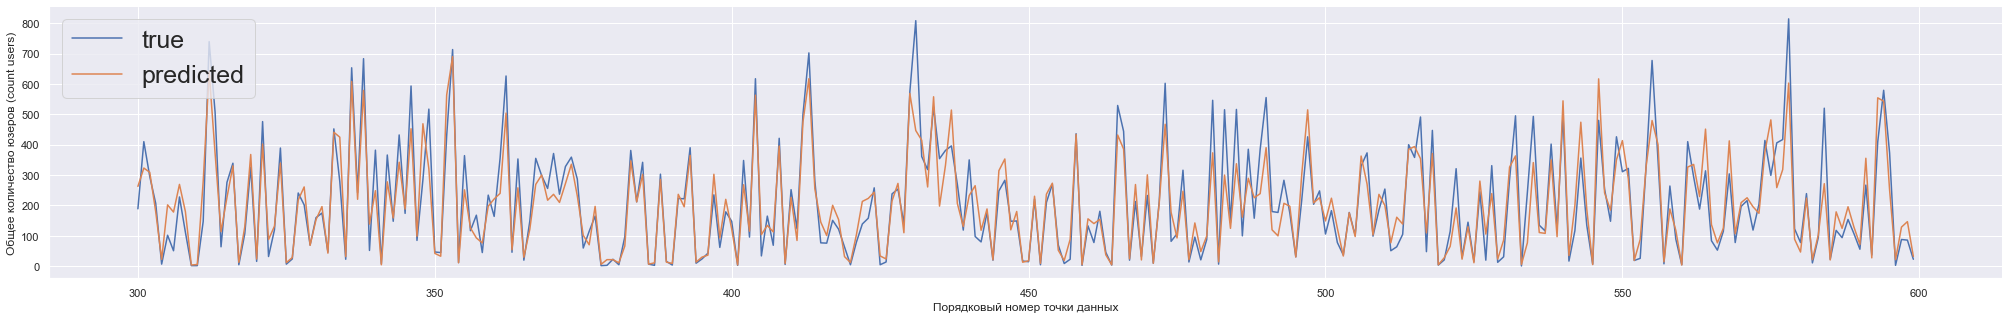

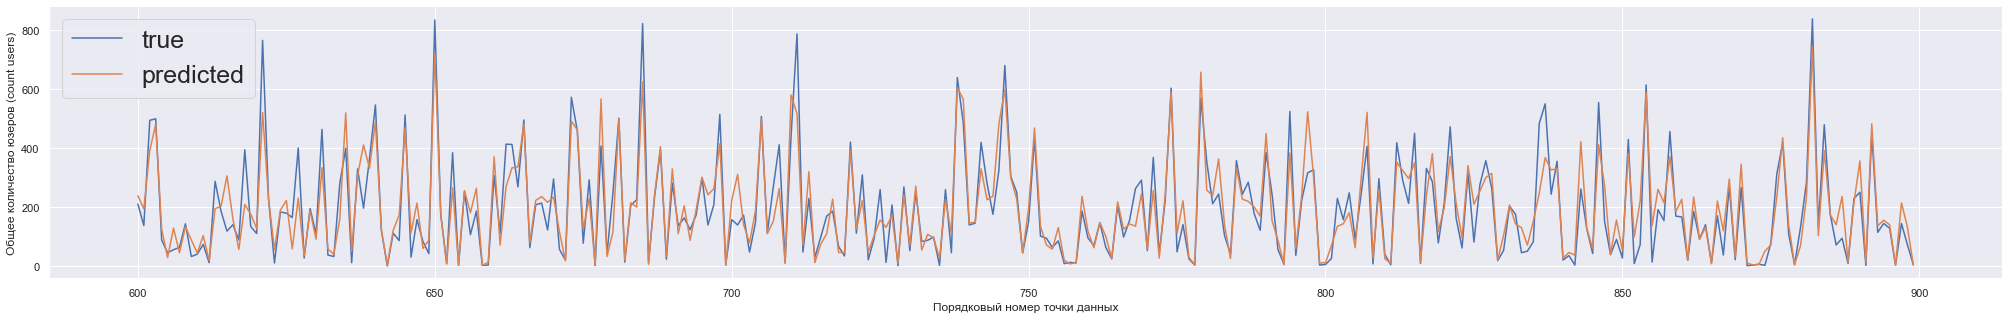

In [109]:
# Сравнение предсказанных и истинных значений на примере первых 900 точек данных:

get_pred_plot(0, 300)
get_pred_plot(300, 600)
get_pred_plot(600, 900)

# Произовдим предсказания для тренировочного датасета: 

    1. Импортируем датасет:

In [110]:
path = r"C:\Users\-\Documents\bikes\test_bikes.csv"

df = pd.read_csv(path, parse_dates=['datetime'])

# Добавим новые столбцы:
df['day_of_week'] = df.datetime.apply(lambda x: x.day_of_week)
df['month'] = df.datetime.apply(lambda x: x.month)
df['date'] = df.datetime.apply(lambda x: x.floor('1D'))
df['hour'] = df.datetime.apply(lambda x: x.hour)

# Преобразуем категориальные столбцы с помощью OneHotEncoder:
cols = ['season', 'holiday', 'workingday', 'weather', 'day_of_week', 'month', 'hour']

for col in cols:
    df = pd.concat([df, get_dummy(col, col)], axis=1)

df = df.drop(cols, axis=1)

    2. Создаем матрицу зависимых переменных:

In [111]:
data = df.drop(['datetime', 'date'], axis=1)

    3. Предсказываем общее кол-во (count) арендаторов:

In [112]:
count_pred = rf.predict(data)

    4. Делаем визуализацию предсказаний:

In [113]:
# Сохраняем список datetime точек данных в список:
datetimes = df.datetime.to_list()

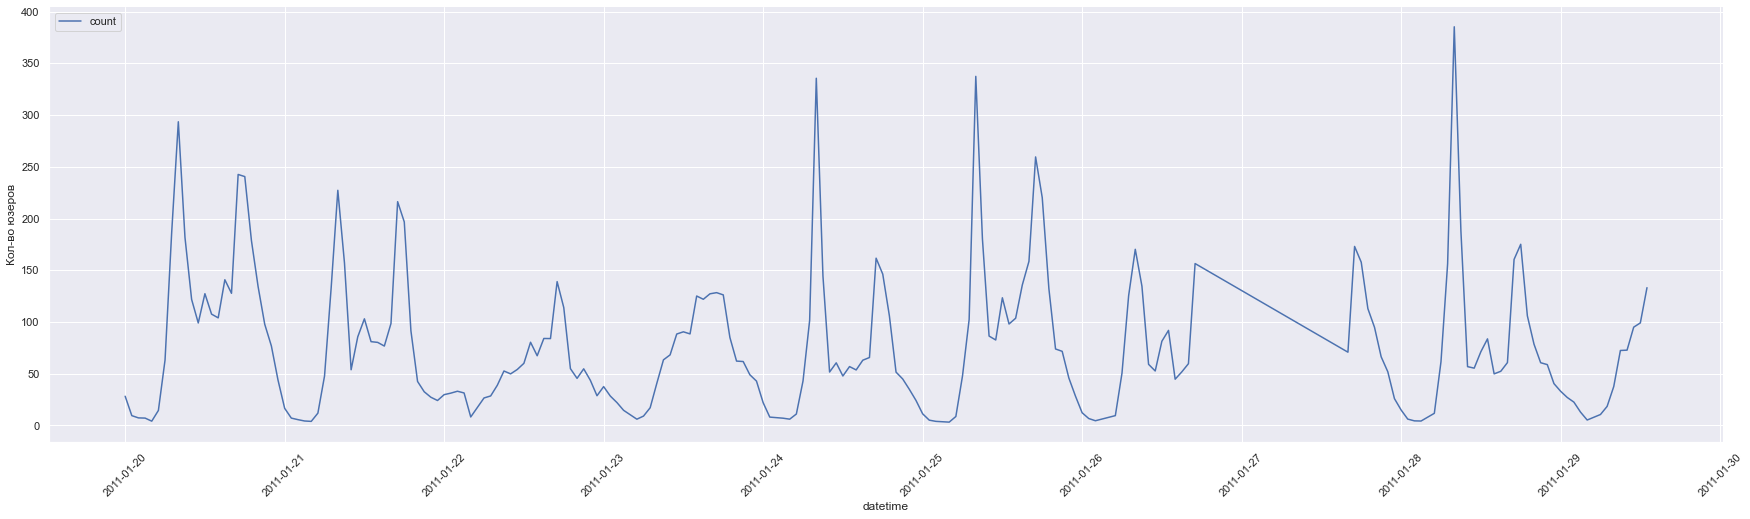

In [121]:
# Предсказанное кол-во юзеров в первых 200 точках данных тестового набора:

fig, ax = plt.subplots(figsize=(30,8)) 

plt.plot(datetimes[:200:], count_pred[:200:])

plt.xlabel('datetime')
plt.ylabel('Кол-во юзеров')
plt.xticks(rotation = 45)
plt.grid(visible=True)
plt.legend(["count", "registered", "casual"], loc ="upper left")

sns.despine()